In [1]:
# type:ignore
import xarray as xr
import numpy as np
import pandas as pd
import h5py
import os
import shutil
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from myLibrary import convertTime, inverseLogTransform, inversTransform, image2Xarray, selectPrecipitation, logTransform

import os
import glob
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import tensorflow as tf

In [2]:
# Define the cropping bounds (Java Island Region) 32 x 96
lat_min, lat_max = -5.65, -8.95    # Latitude range    : 3.2° (32 pixels in 0.1°)
lon_min, lon_max = 105.15, 114.75   # Longitude range   : 9.6° (96 pixels in 0.1°)


# Define the target resolution (e.g., 0.1°)
highResDegree       = 0.1  # Change this to your desired resolution

# Define PreProcessing Method
DoPreProcessing     = True
ReportFolder        = "MIROC6"
# Define Normalized
Normalized          = True

In [3]:
# Path Define
# Get the absolute path 
pathNow = Path().parent.absolute() #See @Arminius answer
pathNow = pathNow.parent
print(pathNow)

# Define the base directory where GCM MIROC6 files are stored
gcmDir  = str(pathNow) + "/Datasets/Hasan"

# Report Filename
ReportFolder    =  str(pathNow) + "\\Reports\\" + ReportFolder 
print(f"GCM directory: {gcmDir}")

# List semua file NC di direktori
nc_files = sorted([f for f in os.listdir(gcmDir) if f.endswith('.nc')])
print(f"Found {len(nc_files)} NetCDF files:")
for file in nc_files:
    print(f"  - {file}")

    
# Create folder and delete if exists
if os.path.exists(ReportFolder):
    shutil.rmtree(ReportFolder)
os.makedirs(ReportFolder) 

print(ReportFolder)

d:\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Hasan.Code
GCM directory: d:\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Hasan.Code/Datasets/Hasan
Found 10 NetCDF files:
  - ina_MIROC6_ssp245_2015_pr.nc
  - ina_MIROC6_ssp245_2016_pr.nc
  - ina_MIROC6_ssp245_2017_pr.nc
  - ina_MIROC6_ssp245_2018_pr.nc
  - ina_MIROC6_ssp245_2019_pr.nc
  - ina_MIROC6_ssp245_2020_pr.nc
  - ina_MIROC6_ssp245_2021_pr.nc
  - ina_MIROC6_ssp245_2022_pr.nc
  - ina_MIROC6_ssp245_2023_pr.nc
  - ina_MIROC6_ssp245_2024_pr.nc
d:\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Hasan.Code\Reports\MIROC6


In [4]:
# Load file untuk tahun 2024
file_2024 = os.path.join(gcmDir, "ina_MIROC6_ssp245_2024_pr.nc")

# Buka dataset
ds_2024 = xr.open_dataset(file_2024)

# Tampilkan informasi dataset
print("Dataset Info:")
print(ds_2024.info())

# Periksa dimensi dan variabel
print("\nDimensions:")
for dim_name, dim_size in ds_2024.dims.items():
    print(f"  {dim_name}: {dim_size}")

print("\nVariables:")
for var_name, var in ds_2024.variables.items():
    print(f"  {var_name}: {var.dims} {var.dtype}")

print("\nCoordinates:")
for coord_name in ds_2024.coords:
    print(f"  {coord_name}: {ds_2024[coord_name].values.min()} to {ds_2024[coord_name].values.max()}")

# Cari variabel presipitasi
pr_var = None
for var in ['pr', 'precipitation', 'precip', 'pre']:
    if var in ds_2024.data_vars:
        pr_var = var
        break

if pr_var:
    print(f"\nPrecipitation Variable: {pr_var}")
    print(f"Units: {ds_2024[pr_var].attrs.get('units', 'Unknown')}")
else:
    print("\nPrecipitation variable not found! Available variables:")
    for var in ds_2024.data_vars:
        print(f"  - {var}")

Dataset Info:
xarray.Dataset {
dimensions:
	time = 366 ;
	lon = 190 ;
	lat = 72 ;

variables:
	datetime64[ns] time(time) ;
		time:standard_name = time ;
		time:long_name = time ;
		time:axis = T ;
	float64 lon(lon) ;
		lon:standard_name = longitude ;
		lon:long_name = longitude ;
		lon:units = degrees_east ;
		lon:axis = X ;
	float64 lat(lat) ;
		lat:standard_name = latitude ;
		lat:long_name = latitude ;
		lat:units = degrees_north ;
		lat:axis = Y ;
	float32 pr(time, lat, lon) ;
		pr:standard_name = precipitation_flux ;
		pr:long_name = Precipitation ;
		pr:units = kg m-2 s-1 ;
		pr:comment = includes both liquid and solid phases ;
		pr:original_name = PRCP ;
		pr:original_units = kg/m**2/s ;
		pr:cell_methods = area: time: mean ;
		pr:cell_measures = area: areacella ;

// global attributes:
	:CDI = Climate Data Interface version 2.1.1 (https://mpimet.mpg.de/cdi) ;
	:Conventions = CF-1.7 ;
	:source = BCSD ;
	:institution = NASA Earth Exchange, NASA Ames Research Center, Moffett Field

C:\Users\BNT RTX3070\AppData\Local\Temp\ipykernel_15692\3933397187.py:13: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for dim_name, dim_size in ds_2024.dims.items():


In [5]:
# Konversi data presipitasi MIROC6 dari kg m-2 s-1 ke mm/day

# Faktor konversi
conversion_factor = 86400  # detik dalam satu hari

# Baca data yang sudah dimuat
if 'ds_2024' in globals() and 'pr' in ds_2024:
    # Ekstrak data presipitasi
    precip_flux = ds_2024['pr']
    
    # Informasi unit awal
    original_units = precip_flux.attrs.get('units', 'kg m-2 s-1')
    print(f"Original units: {original_units}")
    
    # Konversi ke mm/day
    precip_mm_per_day = precip_flux * conversion_factor
    
    # Perbarui atribut metadata
    precip_mm_per_day.attrs['units'] = 'mm/day'
    if 'long_name' in precip_mm_per_day.attrs:
        precip_mm_per_day.attrs['long_name'] = 'Precipitation rate'
    precip_mm_per_day.attrs['note'] = f'Converted from {original_units} to mm/day'
    
    # Tampilkan statistik sebelum dan sesudah konversi
    print(f"\nStatistik Sebelum Konversi ({original_units}):")
    print(f"  Min: {precip_flux.min().values}")
    print(f"  Max: {precip_flux.max().values}")
    print(f"  Mean: {precip_flux.mean().values}")
    
    print(f"\nStatistik Setelah Konversi (mm/day):")
    print(f"  Min: {precip_mm_per_day.min().values}")
    print(f"  Max: {precip_mm_per_day.max().values}")
    print(f"  Mean: {precip_mm_per_day.mean().values}")
    
    
    # Simpan hasil konversi untuk digunakan selanjutnya
    ds_2024_mm_per_day = ds_2024.copy()
    ds_2024_mm_per_day['pr'] = precip_mm_per_day
    
    print("\nDataset dalam mm/day tersedia sebagai 'ds_2024_mm_per_day'")
else:
    print("Dataset MIROC6 belum dimuat atau variabel presipitasi tidak ditemukan!")

Original units: kg m-2 s-1

Statistik Sebelum Konversi (kg m-2 s-1):
  Min: 0.0
  Max: 0.001329264254309237
  Mean: 8.662107575219125e-05

Statistik Setelah Konversi (mm/day):
  Min: 0.0
  Max: 114.84843157231808
  Mean: 7.487168897807876

Dataset dalam mm/day tersedia sebagai 'ds_2024_mm_per_day'


Precipitation Analysis in mm/day:
Shape: (366, 72, 190)
Min value: 0.0000 mm/day
Max value: 114.8484 mm/day
Mean value: 7.4872 mm/day
Std dev: 7.1565 mm/day

Spatial Resolution: 0.25° x 0.25°

Time steps: 366
Time range: 2024-01-01T12:00:00.000000000 to 2024-12-31T12:00:00.000000000

Percentiles (mm/day):
  5%: 0.0000
  25%: 1.2102
  50%: 6.0105
  75%: 11.7949
  95%: 20.5727
  99%: 28.8036

Rainfall Intensity (mm/day):
  No Rain (<0.1): 13.77%
  Light (0.1-5): 31.45%
  Moderate (5-10): 22.59%
  Heavy (10-20): 26.59%
  Very Heavy (20-50): 5.54%
  Extreme (>50): 0.06%


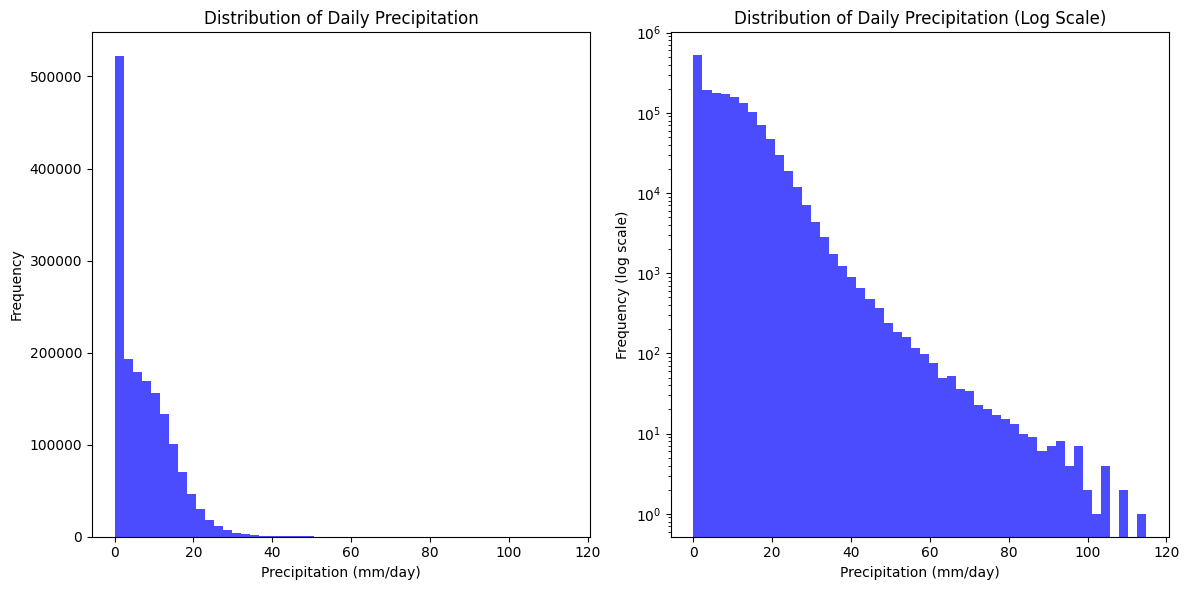

C:\Users\BNT RTX3070\AppData\Roaming\Python\Python310\site-packages\xarray\groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
C:\Users\BNT RTX3070\AppData\Local\Temp\ipykernel_15692\2257007670.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


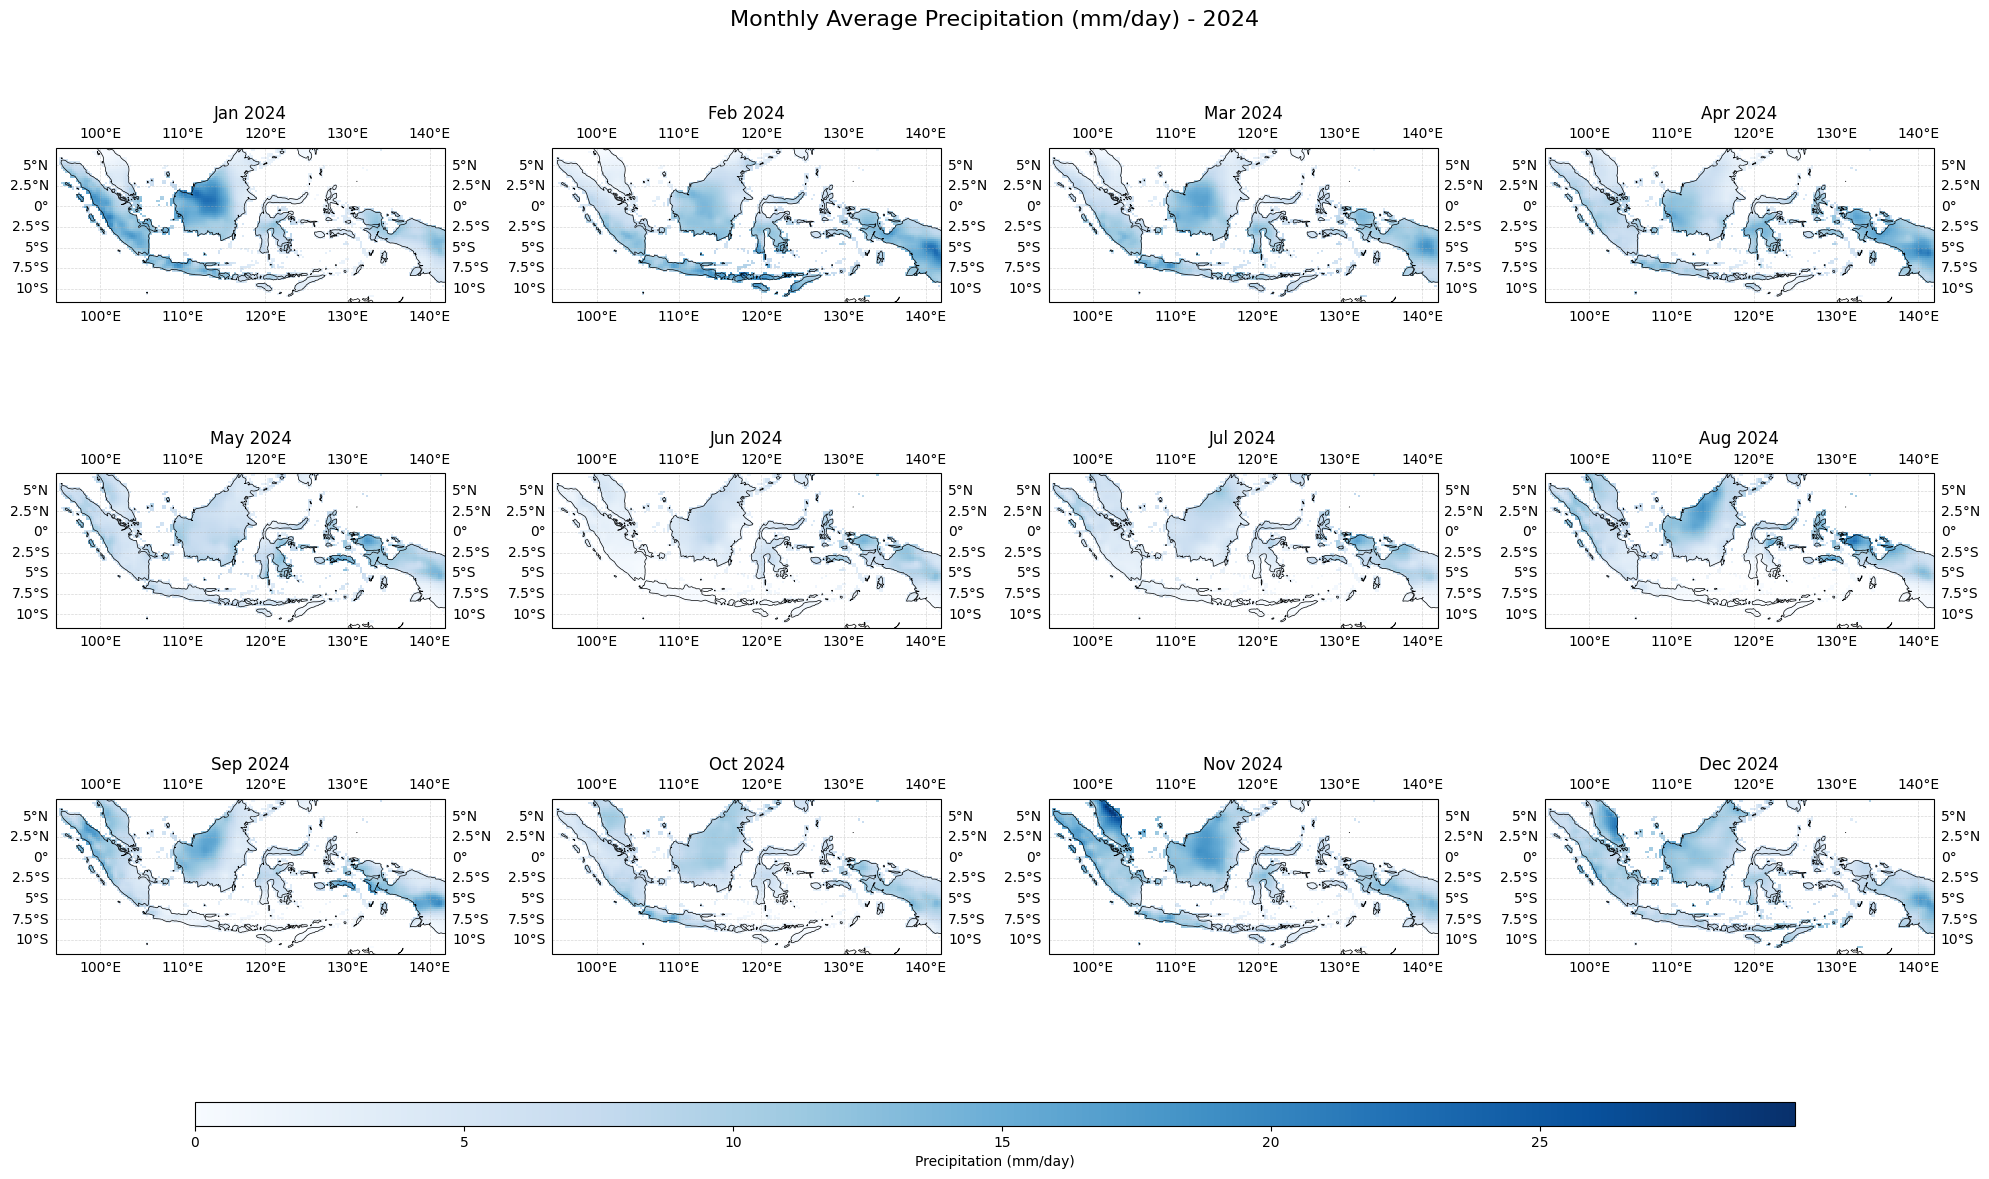

C:\Users\BNT RTX3070\AppData\Roaming\Python\Python310\site-packages\xarray\groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


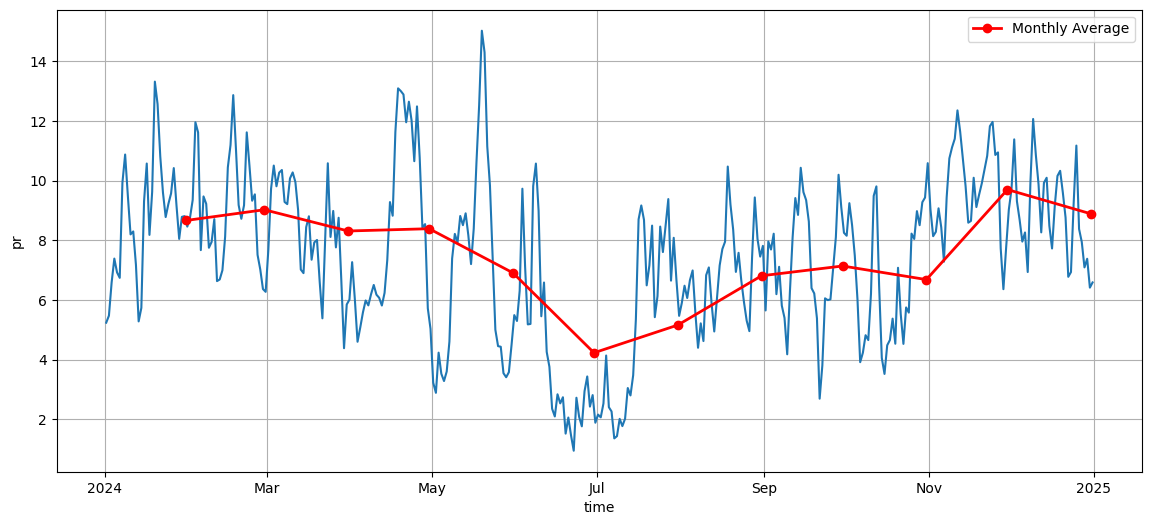

In [6]:
# Analyze precipitation dataset in mm/day
if 'ds_2024_mm_per_day' in globals() and pr_var in ds_2024_mm_per_day:
    # Use the dataset already converted to mm/day
    precip_data_mm_day = ds_2024_mm_per_day[pr_var]
    
    # Statistical values
    print("Precipitation Analysis in mm/day:")
    print(f"Shape: {precip_data_mm_day.shape}")
    print(f"Min value: {precip_data_mm_day.min().values:.4f} mm/day")
    print(f"Max value: {precip_data_mm_day.max().values:.4f} mm/day")
    print(f"Mean value: {precip_data_mm_day.mean().values:.4f} mm/day")
    print(f"Std dev: {precip_data_mm_day.std().values:.4f} mm/day")
    
    # Resolution calculation
    if 'lon' in ds_2024_mm_per_day.coords and 'lat' in ds_2024_mm_per_day.coords:
        lon_res = abs(ds_2024_mm_per_day.lon[1].values - ds_2024_mm_per_day.lon[0].values)
        lat_res = abs(ds_2024_mm_per_day.lat[1].values - ds_2024_mm_per_day.lat[0].values)
        print(f"\nSpatial Resolution: {lon_res}° x {lat_res}°")
    
    # Time steps
    print(f"\nTime steps: {len(ds_2024_mm_per_day.time)}")
    print(f"Time range: {ds_2024_mm_per_day.time.values[0]} to {ds_2024_mm_per_day.time.values[-1]}")
    
    # Distribution of values
    flat_values = precip_data_mm_day.values.flatten()
    flat_values = flat_values[~np.isnan(flat_values)]  # Remove NaN values
    
    # Rainfall intensity classification
    rain_intensity_thresholds = [0.1, 5, 10, 20, 50, 100]
    rain_intensity_labels = ['No Rain (<0.1)', 'Light (0.1-5)', 'Moderate (5-10)', 
                           'Heavy (10-20)', 'Very Heavy (20-50)', 'Extreme (>50)']
    
    # Calculate percentage for each category
    rain_percentages = []
    rain_percentages.append(100 * np.sum(flat_values < rain_intensity_thresholds[0]) / len(flat_values))
    
    for i in range(len(rain_intensity_thresholds)-1):
        lower = rain_intensity_thresholds[i]
        upper = rain_intensity_thresholds[i+1]
        percentage = 100 * np.sum((flat_values >= lower) & (flat_values < upper)) / len(flat_values)
        rain_percentages.append(percentage)
    
    rain_percentages.append(100 * np.sum(flat_values >= rain_intensity_thresholds[-1]) / len(flat_values))
    
    # Calculate percentiles
    percentiles = [5, 25, 50, 75, 95, 99]
    percentile_values = np.percentile(flat_values, percentiles)
    
    print("\nPercentiles (mm/day):")
    for p, val in zip(percentiles, percentile_values):
        print(f"  {p}%: {val:.4f}")
    
    print("\nRainfall Intensity (mm/day):")
    for label, percentage in zip(rain_intensity_labels, rain_percentages):
        print(f"  {label}: {percentage:.2f}%")
    
    # Plot histogram
    plt.figure(figsize=(12, 6))
    
    # Main histogram
    plt.subplot(1, 2, 1)
    plt.hist(flat_values, bins=50, alpha=0.7, color='blue')
    plt.xlabel('Precipitation (mm/day)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Daily Precipitation')
    
    # Histogram with logarithmic scale
    plt.subplot(1, 2, 2)
    plt.hist(flat_values, bins=50, alpha=0.7, color='blue', log=True)
    plt.xlabel('Precipitation (mm/day)')
    plt.ylabel('Frequency (log scale)')
    plt.title('Distribution of Daily Precipitation (Log Scale)')
    plt.tight_layout()
    plt.savefig(os.path.join(ReportFolder, 'Distribution Precipitation.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    
    # FIXED: Monthly visualization - Option 2: Plot each month separately
    # Calculate monthly averages
    monthly_data = precip_data_mm_day.resample(time='1M').mean()
    
    # Create a 3x4 grid for the 12 months
    fig, axes = plt.subplots(3, 4, figsize=(20, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()
    
    # Month names for titles
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Common colorbar range for all plots
    vmin = monthly_data.min().values
    vmax = monthly_data.max().values
    
    # Plot each month
    for i, (ax, month_name) in enumerate(zip(axes, month_names)):
        if i < len(monthly_data.time):
            monthly_data.isel(time=i).plot(ax=ax, cmap='Blues', 
                                          vmin=vmin, vmax=vmax,
                                          add_colorbar=False)
            ax.set_title(f'{month_name} 2024')
            ax.coastlines(linewidth=0.5)
            ax.set_extent([94.625, 141.875, -10.875, 6.875])
            ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
    
    # Add a colorbar at the bottom
    cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Precipitation (mm/day)')
    
    plt.suptitle('Monthly Average Precipitation (mm/day) - 2024', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.savefig(os.path.join(ReportFolder, 'Monthly Average Precipitation 2024.png'), dpi=600, bbox_inches='tight')
    plt.show()
    
    # Time series plot of area-averaged precipitation
    plt.figure(figsize=(14, 6))
    mean_over_area = precip_data_mm_day.mean(dim=['lat', 'lon'])
    mean_over_area.plot()
    plt.title('Domain-Averaged Daily Precipitation (mm/day)')
    plt.xlabel('Time')
    plt.ylabel('Precipitation (mm/day)')
    plt.grid(True)
    
    # Add monthly average line
    monthly_mean = mean_over_area.resample(time='1M').mean()
    monthly_mean.plot(marker='o', color='red', linestyle='-', linewidth=2, label='Monthly Average')
    
    plt.legend()
    plt.savefig(os.path.join(ReportFolder, 'Domain-Averaged Daily Precipitation.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    # If mm/day dataset hasn't been created, convert it first
    if pr_var and pr_var in ds_2024:
        print("Dataset not yet converted to mm/day. Performing conversion first.")
        
        # Conversion factor from kg m-2 s-1 to mm/day
        conversion_factor = 86400
        
        # Convert to mm/day
        precip_data_mm_day = ds_2024[pr_var] * conversion_factor
        precip_data_mm_day.attrs['units'] = 'mm/day'
        
        # Continue with the same analysis
        print("Precipitation Analysis in mm/day (after conversion):")
        print(f"Shape: {precip_data_mm_day.shape}")
        print(f"Min value: {precip_data_mm_day.min().values:.4f} mm/day")
        print(f"Max value: {precip_data_mm_day.max().values:.4f} mm/day")
        print(f"Mean value: {precip_data_mm_day.mean().values:.4f} mm/day")
        print(f"Std dev: {precip_data_mm_day.std().values:.4f} mm/day")
        
        # Save the conversion result
        ds_2024_mm_per_day = ds_2024.copy()
        ds_2024_mm_per_day[pr_var] = precip_data_mm_day
    else:
        print("Precipitation variable not found in the dataset!")

In [7]:
# Extract time information from the MIROC6 dataset
time_coord = ds_2024.coords['time']
time_info = {}

# Extract basic time information
time_info['time_units'] = time_coord.attrs.get('units', 'Not specified')
time_info['calendar'] = time_coord.attrs.get('calendar', 'Not specified')
time_info['start_date'] = pd.Timestamp(time_coord.values[0]).strftime('%Y-%m-%d %H:%M:%S')
time_info['end_date'] = pd.Timestamp(time_coord.values[-1]).strftime('%Y-%m-%d %H:%M:%S')
time_info['num_timesteps'] = len(time_coord)

# Calculate time resolution
if len(time_coord) > 1:
    time_diff = pd.Timestamp(time_coord.values[1]) - pd.Timestamp(time_coord.values[0])
    time_info['time_resolution'] = str(time_diff)
    
    # Check if time steps are regular
    time_diffs = np.array([
        (pd.Timestamp(time_coord.values[i+1]) - pd.Timestamp(time_coord.values[i])).total_seconds()
        for i in range(len(time_coord)-1)
    ])
    time_info['regular_timesteps'] = np.allclose(time_diffs, time_diffs[0])
else:
    time_info['time_resolution'] = 'Single timestep'
    time_info['regular_timesteps'] = None

# Extract all years, months, and available time periods
dates = pd.DatetimeIndex(time_coord.values)
time_info['years'] = sorted(list(set(dates.year)))
time_info['months'] = sorted(list(set(dates.month)))
time_info['days'] = sorted(list(set(dates.day)))
time_info['hours'] = sorted(list(set(dates.hour)))

print("\n===== MIROC6 Time Details =====")
print(f"Time units: {time_info['time_units']}")
print(f"Calendar: {time_info['calendar']}")
print(f"Start date: {time_info['start_date']}")
print(f"End date: {time_info['end_date']}")
print(f"Number of timesteps: {time_info['num_timesteps']}")
print(f"Time resolution: {time_info['time_resolution']}")
print(f"Regular timesteps: {time_info['regular_timesteps']}")
print(f"Years available: {time_info['years']}")
print(f"Months available: {time_info['months']}")
print(f"Days available: {time_info['days']}")
print(f"Hours available: {time_info['hours']}")


===== MIROC6 Time Details =====
Time units: Not specified
Calendar: Not specified
Start date: 2024-01-01 12:00:00
End date: 2024-12-31 12:00:00
Number of timesteps: 366
Time resolution: 1 days 00:00:00
Regular timesteps: True
Years available: [2024]
Months available: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Days available: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Hours available: [12]


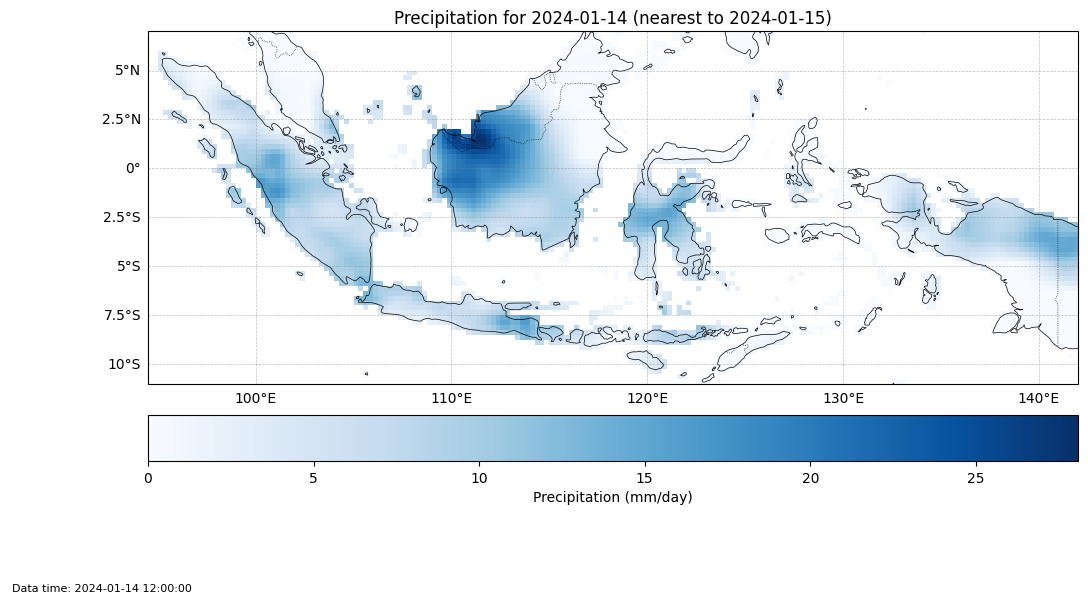

In [8]:
def plot_precipitation_for_date(dataset, date_str, pr_var='pr', cmap='Blues', 
                               add_coastlines=True, add_gridlines=True, 
                               figsize=(12, 8), title=None, vmin=None, vmax=None):
    """
    Plot precipitation data for a specific date.
    
    Parameters:
    -----------
    dataset : xarray.Dataset
        The dataset containing precipitation data (e.g., ds_2024 or ds_2024_mm_per_day)
    date_str : str
        Date string in format 'YYYY-MM-DD' (e.g., '2024-06-15')
    pr_var : str, optional
        Name of precipitation variable (default: 'pr')
    cmap : str, optional
        Colormap name (default: 'Blues')
    add_coastlines : bool, optional
        Whether to add coastlines to the plot (default: True)
    add_gridlines : bool, optional
        Whether to add gridlines to the plot (default: True)
    figsize : tuple, optional
        Figure size (width, height) in inches (default: (12, 8))
    title : str, optional
        Custom title (if None, a default title will be generated)
    vmin, vmax : float, optional
        Min and max values for colorbar. If None, they're determined from the data.
    
    Returns:
    --------
    fig, ax : matplotlib Figure and Axes objects
    """
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import numpy as np
    import pandas as pd
    
    # Convert date string to pandas datetime
    date = pd.to_datetime(date_str)
    
    # Find the nearest time in the dataset
    time_index = np.abs(dataset.time.values - np.datetime64(date)).argmin()
    actual_date = pd.to_datetime(dataset.time.values[time_index])
    
    # Get data for this date
    data = dataset[pr_var].isel(time=time_index)
    
    # Check units for title
    units = data.attrs.get('units', 'Unknown units')
    
    # Set up the figure with cartopy projection
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Plot the data
    im = data.plot(ax=ax, cmap=cmap, transform=ccrs.PlateCarree(),
                  add_colorbar=False, vmin=vmin, vmax=vmax)
    
    # Add a colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, 
                        label=f'Precipitation ({units})')
    
    # Add coastlines if requested
    if add_coastlines:
        ax.coastlines(linewidth=0.5, color='black')
        ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
        ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.1)
    
    # Add gridlines if requested
    if add_gridlines:
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
    
    # Set title
    if title is None:
        if date != actual_date:
            title = f"Precipitation for {actual_date.strftime('%Y-%m-%d')} (nearest to {date.strftime('%Y-%m-%d')})"
        else:
            title = f"Precipitation for {date.strftime('%Y-%m-%d')}"
    
    ax.set_title(title)
    
    # Add timestamp for reference
    plt.annotate(f"Data time: {pd.to_datetime(data.time.values).strftime('%Y-%m-%d %H:%M:%S')}", 
                xy=(0.01, 0.01), xycoords='figure fraction', fontsize=8)
    
    return fig, ax

# Example usage:
# To use this function, simply call it with your dataset and desired date:
# 
# # For original units (kg m-2 s-1)
# fig, ax = plot_precipitation_for_date(ds_2024, '2024-06-15')
# plt.show()
# 
# # For mm/day (if converted)
if 'ds_2024_mm_per_day' in globals():
    fig, ax = plot_precipitation_for_date(ds_2024_mm_per_day, '2024-01-15')
    plt.show()

In [9]:
# 1. Generate grid baru dengan resolusi 0.1° untuk seluruh domain Indonesia
# Gunakan batas domain dari MIROC6 asli
lat_range = [ds_2024.lat.min().item(), ds_2024.lat.max().item()]
lon_range = [ds_2024.lon.min().item(), ds_2024.lon.max().item()]

# Buat grid baru dengan resolusi 0.1°
new_lat = np.arange(lat_range[0], lat_range[1] + 0.1, 0.1)  # +0.1 untuk memastikan batas atas termasuk
new_lon = np.arange(lon_range[0], lon_range[1] + 0.1, 0.1)

print(f"Original grid shape: {len(ds_2024.lat)} x {len(ds_2024.lon)}")
print(f"New grid shape: {len(new_lat)} x {len(new_lon)}")

# 2. Interpolasi MIROC6 ke grid resolusi tinggi
ds_highres = ds_2024.interp(lat=new_lat, lon=new_lon, method="linear")

# Untuk dataset mm/day jika ada
if 'ds_2024_mm_per_day' in globals():
    ds_highres_mm = ds_2024_mm_per_day.interp(lat=new_lat, lon=new_lon, method="linear")

# 3. Slice untuk area Jawa
# Define Java Island coordinates
lat_min, lat_max = -8.95, -5.65
lon_min, lon_max = 105.15, 114.75

# Verifikasi bahwa koordinat berada dalam grid baru
# (ini bisa diabaikan jika yakin koordinat berada dalam domain)
lat_in_grid = (lat_min >= new_lat.min()) and (lat_max <= new_lat.max())
lon_in_grid = (lon_min >= new_lon.min()) and (lon_max <= new_lon.max())

if not (lat_in_grid and lon_in_grid):
    print("Warning: Java coordinates may be outside the interpolated grid!")
    print(f"Grid latitude range: {new_lat.min()} to {new_lat.max()}")
    print(f"Grid longitude range: {new_lon.min()} to {new_lon.max()}")
    print(f"Java latitude range: {lat_min} to {lat_max}")
    print(f"Java longitude range: {lon_min} to {lon_max}")

# Check if we need to reverse the latitude range
if ds_highres.lat[0] > ds_highres.lat[-1]:
    # Dataset has descending latitude values
    lat_slice = slice(lat_max, lat_min)  # Swap the order
else:
    # Dataset has ascending latitude values
    lat_slice = slice(lat_min, lat_max)

# Slice the high-resolution dataset for Java Island
ds_java_highres = ds_highres.sel(lat=lat_slice, lon=slice(lon_min, lon_max))

# For mm/day dataset if it exists
if 'ds_highres_mm' in locals():
    ds_java_highres_mm = ds_highres_mm.sel(lat=lat_slice, lon=slice(lon_min, lon_max))

# 4. Cek hasil
print("\nJava Island high-resolution subset information:")
print(f"Shape (time, lat, lon): {ds_java_highres[pr_var].shape}")
print(f"Latitude range: {ds_java_highres.lat.values.min()} to {ds_java_highres.lat.values.max()}")
print(f"Longitude range: {ds_java_highres.lon.values.min()} to {ds_java_highres.lon.values.max()}")

# Calculate the actual resolution of the interpolated dataset
if len(ds_java_highres.lat) > 1 and len(ds_java_highres.lon) > 1:
    lat_res = abs(ds_java_highres.lat[1] - ds_java_highres.lat[0])
    lon_res = abs(ds_java_highres.lon[1] - ds_java_highres.lon[0])
    print(f"Actual resolution: {lat_res}° × {lon_res}°")

# Expected dimensions for Java at 0.1° resolution
expected_lat_pixels = int(abs(lat_max - lat_min) / 0.1)
expected_lon_pixels = int(abs(lon_max - lon_min) / 0.1)
print(f"Expected dimensions at 0.1° resolution: {expected_lat_pixels} × {expected_lon_pixels}")
print(f"Actual dimensions: {len(ds_java_highres.lat)} × {len(ds_java_highres.lon)}")

# 5. Verifikasi kesesuaian dimensi dengan model
target_shape = (32, 96)  # Sesuai informasi model Anda
actual_shape = (len(ds_java_highres.lat), len(ds_java_highres.lon))

if actual_shape == target_shape:
    print("\nSuccess! The dataset shape matches the target model input shape.")
else:
    print("\nWarning: The dataset shape does not match the target model input shape.")
    print(f"Target shape: {target_shape}")
    print(f"Actual shape: {actual_shape}")
    
    # Jika dimensi tidak cocok, berikan opsi untuk menyesuaikan
    print("\nOptions for adjustment:")
    print("1. Adjust the Java Island bounds slightly")
    print("2. Perform an additional interpolation step to match exact dimensions")

Original grid shape: 72 x 190
New grid shape: 179 x 474

Java Island high-resolution subset information:
Shape (time, lat, lon): (366, 33, 96)
Latitude range: -8.875000000000007 to -5.6750000000000185
Longitude range: 105.2249999999994 to 114.72499999999886
Actual resolution: <xarray.DataArray 'lat' ()> Size: 8B
array(0.1)° × <xarray.DataArray 'lon' ()> Size: 8B
array(0.1)°
Expected dimensions at 0.1° resolution: 32 × 95
Actual dimensions: 33 × 96

Target shape: (32, 96)
Actual shape: (33, 96)

Options for adjustment:
1. Adjust the Java Island bounds slightly
2. Perform an additional interpolation step to match exact dimensions


In [10]:
# Define Java Island coordinates
lat_min, lat_max = -8.95, -5.65     # Latitude range    : 3.3° (33 pixels at 0.1° resolution)
lon_min, lon_max = 105.15, 114.75   # Longitude range   : 9.6° (96 pixels at 0.1° resolution)

# Check if we need to reverse the latitude range (some datasets have descending lat coordinates)
if ds_2024.lat[0] > ds_2024.lat[-1]:
    # Dataset has descending latitude values (e.g., 10, 9, 8, ...)
    lat_slice = slice(lat_max, lat_min)  # Swap the order
else:
    # Dataset has ascending latitude values (e.g., -10, -9, -8, ...)
    lat_slice = slice(lat_min, lat_max)

# Slice MIROC6 dataset for Java Island
ds_java = ds_2024.sel(lat=lat_slice, lon=slice(lon_min, lon_max))

# For mm/day dataset if it exists
if 'ds_2024_mm_per_day' in globals():
    ds_java_mm = ds_2024_mm_per_day.sel(lat=lat_slice, lon=slice(lon_min, lon_max))

# Print information about the sliced dataset
print("\nJava Island subset information:")
print(f"Original dimensions: {ds_2024.dims}")
print(f"Java subset dimensions: {ds_java.dims}")

# Check the actual lat/lon ranges to confirm we captured Java correctly
print(f"\nLatitude range: {ds_java.lat.values.min()} to {ds_java.lat.values.max()}")
print(f"Longitude range: {ds_java.lon.values.min()} to {ds_java.lon.values.max()}")

# Check actual data dimensions
print(f"\nData shape (time, lat, lon): {ds_java[pr_var].shape}")

# Calculate expected dimensions for 0.1° resolution
expected_lat_pixels = int(abs(lat_max - lat_min) / 0.1)
expected_lon_pixels = int(abs(lon_max - lon_min) / 0.1)
print(f"Expected dimensions at 0.1° resolution: {expected_lat_pixels} × {expected_lon_pixels}")

# Calculate actual resolution
if len(ds_java.lat) > 1 and len(ds_java.lon) > 1:
    lat_res = abs(ds_java.lat[1] - ds_java.lat[0])
    lon_res = abs(ds_java.lon[1] - ds_java.lon[0])
    print(f"Actual dataset resolution: {lat_res}° × {lon_res}°")
    
    # Calculate actual dimensions based on actual resolution
    actual_lat_pixels = int(abs(lat_max - lat_min) / lat_res)
    actual_lon_pixels = int(abs(lon_max - lon_min) / lon_res)
    print(f"Expected dimensions at {lat_res}° resolution: {actual_lat_pixels} × {actual_lon_pixels}")
# Save sliced dataset for further use
ds_java_2024 = ds_java  # Rename for clarity
if 'ds_java_mm' in locals():
    ds_java_2024_mm = ds_java_mm


Java Island subset information:
Original dimensions: FrozenMappingWarningOnValuesAccess({'time': 366, 'lon': 190, 'lat': 72})
Java subset dimensions: FrozenMappingWarningOnValuesAccess({'time': 366, 'lon': 38, 'lat': 13})

Latitude range: -8.875 to -5.875
Longitude range: 105.375 to 114.625

Data shape (time, lat, lon): (366, 13, 38)
Expected dimensions at 0.1° resolution: 32 × 95
Actual dataset resolution: <xarray.DataArray 'lat' ()> Size: 8B
array(0.25)° × <xarray.DataArray 'lon' ()> Size: 8B
array(0.25)°
Expected dimensions at <xarray.DataArray 'lat' ()> Size: 8B
array(0.25)° resolution: 13 × 38


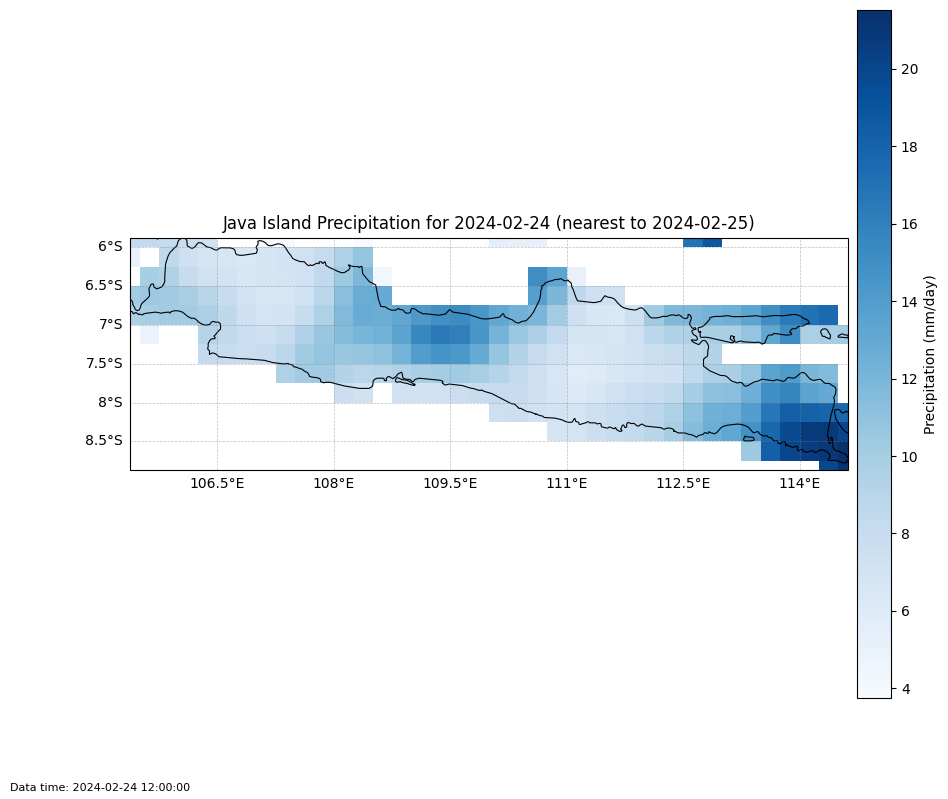

In [11]:
def plot_java_precipitation_mm(date_str, pr_var='pr', cmap='Blues', 
                             add_coastlines=True, add_gridlines=True, 
                             figsize=(10, 8), title=None, vmin=None, vmax=None):
    """
    Plot precipitation data for Java Island for a specific date in mm/day.
    
    Parameters:
    -----------
    date_str : str
        Date string in format 'YYYY-MM-DD' (e.g., '2024-06-15')
    pr_var : str, optional
        Name of precipitation variable (default: 'pr')
    cmap : str, optional
        Colormap name (default: 'Blues')
    add_coastlines : bool, optional
        Whether to add coastlines to the plot (default: True)
    add_gridlines : bool, optional
        Whether to add gridlines to the plot (default: True)
    figsize : tuple, optional
        Figure size (width, height) in inches (default: (10, 8))
    title : str, optional
        Custom title (if None, a default title will be generated)
    vmin, vmax : float, optional
        Min and max values for colorbar. If None, they're determined from the data.
    
    Returns:
    --------
    fig, ax : matplotlib Figure and Axes objects
    """
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import numpy as np
    import pandas as pd
    
    # Check if dataset exists
    if 'ds_java_2024_mm' not in globals():
        raise ValueError("Dataset ds_java_2024_mm not found. Please run the slicing code first.")
    
    # Convert date string to pandas datetime
    date = pd.to_datetime(date_str)
    
    # Find the nearest time in the dataset
    time_index = np.abs(ds_java_2024_mm.time.values - np.datetime64(date)).argmin()
    actual_date = pd.to_datetime(ds_java_2024_mm.time.values[time_index])
    
    # Get data for this date
    data = ds_java_2024_mm[pr_var].isel(time=time_index)
    
    # Check units for title
    units = data.attrs.get('units', 'mm/day')
    
    # Set up the figure with cartopy projection
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Plot the data
    im = data.plot(ax=ax, cmap=cmap, transform=ccrs.PlateCarree(),
                  add_colorbar=False, vmin=vmin, vmax=vmax)
    
    # Add a colorbar - vertical on the right
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.01, 
                       label=f'Precipitation ({units})')
    
    # Add coastlines if requested
    if add_coastlines:
        ax.coastlines(resolution='10m', linewidth=0.8)
        ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
        ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.1)
    
    # Add gridlines if requested
    if add_gridlines:
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
    
    # Set extent to Java Island
    lon_min, lon_max = ds_java_2024_mm.lon.min().values, ds_java_2024_mm.lon.max().values
    lat_min, lat_max = ds_java_2024_mm.lat.min().values, ds_java_2024_mm.lat.max().values
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    
    # Set title
    if title is None:
        if date != actual_date:
            title = f"Java Island Precipitation for {actual_date.strftime('%Y-%m-%d')} (nearest to {date.strftime('%Y-%m-%d')})"
        else:
            title = f"Java Island Precipitation for {date.strftime('%Y-%m-%d')}"
    
    ax.set_title(title)
    
    # Add timestamp for reference
    plt.annotate(f"Data time: {pd.to_datetime(data.time.values).strftime('%Y-%m-%d %H:%M:%S')}", 
                xy=(0.01, 0.01), xycoords='figure fraction', fontsize=8)
    
    plt.tight_layout()
    
    return fig, ax

# Example usage:
# To plot a specific date for the Java Island subset in mm/day:
fig, ax = plot_java_precipitation_mm('2024-02-25')
plt.savefig('java_precipitation_mm_day.png', dpi=300, bbox_inches='tight')
plt.show()

Current dataset resolution: <xarray.DataArray 'lat' ()> Size: 8B
array(0.25)° × <xarray.DataArray 'lon' ()> Size: 8B
array(0.25)°
Upsampling from <xarray.DataArray 'lat' ()> Size: 8B
array(0.25)° to 0.1° resolution...
Interpolating to new grid with dimensions: lat=31, lon=94
Original dimensions: FrozenMappingWarningOnValuesAccess({'time': 366, 'lon': 38, 'lat': 13})
New high-resolution dimensions: FrozenMappingWarningOnValuesAccess({'time': 366, 'lat': 31, 'lon': 94})
Expected dimensions at 0.1° resolution: 31 × 93


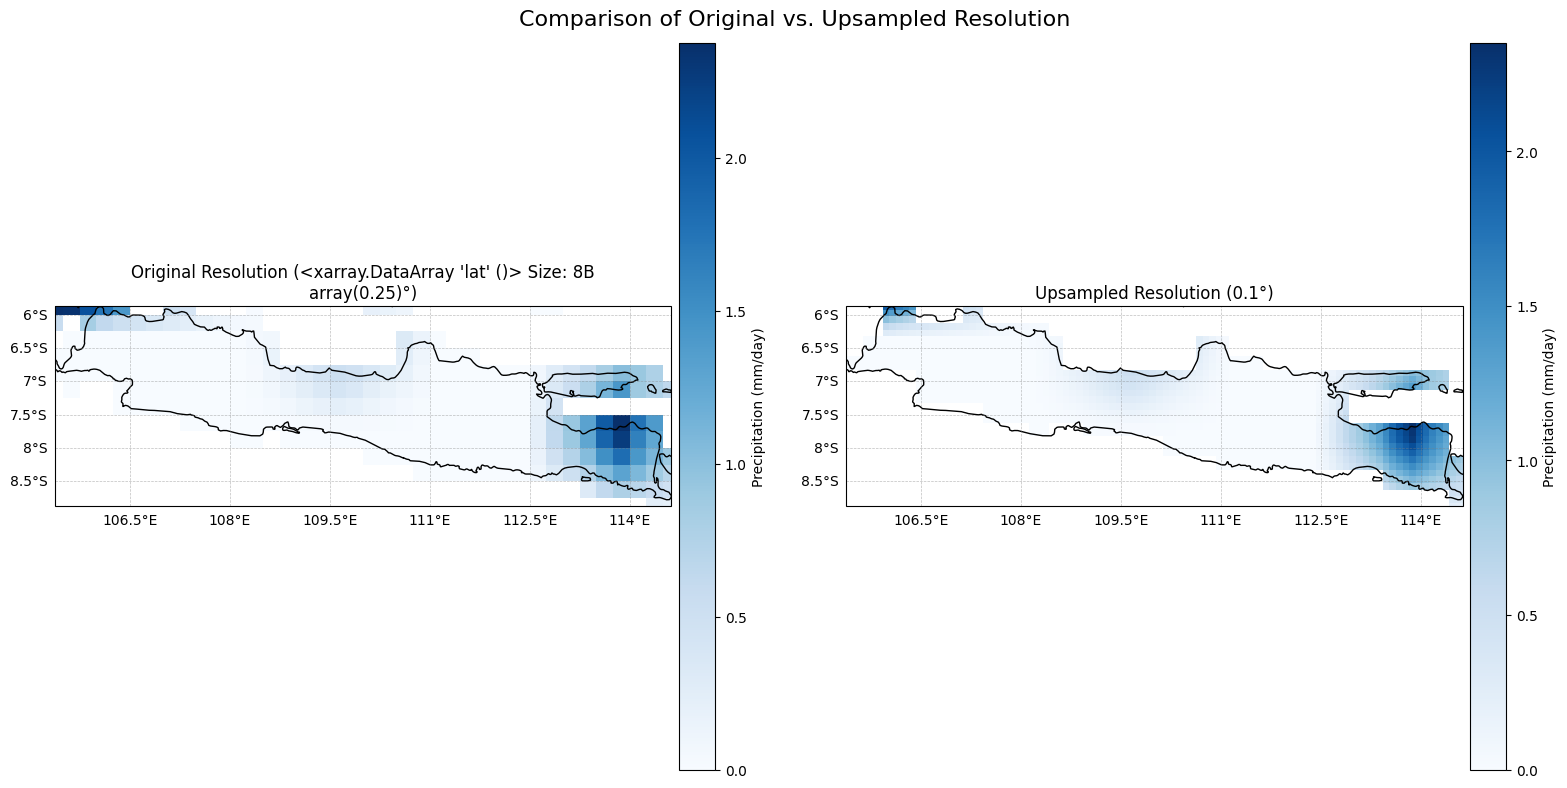


Checking dimensions for GAN model compatibility:
Current dimensions: 31 × 94
Target GAN dimensions: 32 × 96
Dimensions don't match target GAN dimensions. May need additional resizing.
Scale factors needed - Latitude: 1.032, Longitude: 1.021


In [12]:
# Upsampling MIROC6 data for Java to 0.1° resolution
# Define the target resolution (e.g., 0.1°)
highResDegree       = 0.1  # Change this to your desired resolution

# First, check the current resolution of the dataset
if len(ds_java_2024_mm.lat) > 1 and len(ds_java_2024_mm.lon) > 1:
    lat_res = abs(ds_java_2024_mm.lat[1] - ds_java_2024_mm.lat[0])
    lon_res = abs(ds_java_2024_mm.lon[1] - ds_java_2024_mm.lon[0])
    print(f"Current dataset resolution: {lat_res}° × {lon_res}°")
    
    if lat_res <= highResDegree and lon_res <= highResDegree:
        print(f"Dataset already at {lat_res}° resolution, which is finer than or equal to the target {highResDegree}° resolution.")
        # Just use the existing dataset
        ds_java_highres_mm = ds_java_2024_mm
    else:
        print(f"Upsampling from {lat_res}° to {highResDegree}° resolution...")

        # Generate new latitude and longitude grids at 0.1° resolution
        # Note: Need to handle ascending vs descending latitudes
        lat_min, lat_max = ds_java_2024_mm.lat.min().values, ds_java_2024_mm.lat.max().values
        lon_min, lon_max = ds_java_2024_mm.lon.min().values, ds_java_2024_mm.lon.max().values
        
        # For latitude, need to ensure proper direction based on dataset
        if ds_java_2024_mm.lat[0] > ds_java_2024_mm.lat[-1]:  # Descending
            new_lat = np.arange(lat_max, lat_min, -highResDegree)  # Descending order
        else:  # Ascending
            new_lat = np.arange(lat_min, lat_max, highResDegree)  # Ascending order
            
        new_lon = np.arange(lon_min, lon_max, highResDegree)
        
        # Ensure we include the end points
        if new_lat[-1] != lat_max and new_lat[0] != lat_max:
            if ds_java_2024_mm.lat[0] > ds_java_2024_mm.lat[-1]:  # Descending
                new_lat = np.append(new_lat, lat_min)
            else:  # Ascending
                new_lat = np.append(new_lat, lat_max)
                
        if new_lon[-1] != lon_max:
            new_lon = np.append(new_lon, lon_max)
        
        # Interpolate data onto the finer resolution grid
        print(f"Interpolating to new grid with dimensions: lat={len(new_lat)}, lon={len(new_lon)}")
        
        # Perform interpolation
        ds_java_highres_mm = ds_java_2024_mm.interp(lat=new_lat, lon=new_lon, method="linear")
        
        # Report the resulting dimensions
        print(f"Original dimensions: {ds_java_2024_mm.dims}")
        print(f"New high-resolution dimensions: {ds_java_highres_mm.dims}")
        
        # Calculate resulting grid size
        expected_lat_pixels = int(abs(lat_max - lat_min) / highResDegree) + 1
        expected_lon_pixels = int(abs(lon_max - lon_min) / highResDegree) + 1
        print(f"Expected dimensions at {highResDegree}° resolution: {expected_lat_pixels} × {expected_lon_pixels}")
else:
    print("Error: Cannot determine dataset resolution.")

# Visualize comparison between original and high-resolution data
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Plot the first timestep for comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Original resolution
im1 = ds_java_2024_mm[pr_var].isel(time=0).plot(
    ax=axes[0], transform=ccrs.PlateCarree(), cmap='Blues',
    add_colorbar=False
)
plt.colorbar(im1, ax=axes[0], orientation='vertical', pad=0.01, label='Precipitation (mm/day)')
axes[0].set_title(f'Original Resolution ({lat_res}°)')
axes[0].coastlines(resolution='10m')
axes[0].add_feature(cfeature.BORDERS, linestyle=':')

# High-resolution
im2 = ds_java_highres_mm[pr_var].isel(time=0).plot(
    ax=axes[1], transform=ccrs.PlateCarree(), cmap='Blues',
    add_colorbar=False
)
plt.colorbar(im2, ax=axes[1], orientation='vertical', pad=0.01, label='Precipitation (mm/day)')
axes[1].set_title(f'Upsampled Resolution ({highResDegree}°)')
axes[1].coastlines(resolution='10m')
axes[1].add_feature(cfeature.BORDERS, linestyle=':')

# Set the same extent for both plots
for ax in axes:
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

plt.suptitle('Comparison of Original vs. Upsampled Resolution', fontsize=16)
plt.tight_layout()
plt.savefig('java_resolution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Check if dimensions are close to target for GAN model
print("\nChecking dimensions for GAN model compatibility:")
actual_lat_count = len(ds_java_highres_mm.lat)
actual_lon_count = len(ds_java_highres_mm.lon)
print(f"Current dimensions: {actual_lat_count} × {actual_lon_count}")
print(f"Target GAN dimensions: 32 × 96")

if actual_lat_count == 32 and actual_lon_count == 96:
    print("Perfect match for GAN model!")
else:
    print(f"Dimensions don't match target GAN dimensions. May need additional resizing.")
    
    # Optional: Calculate scaling factor needed
    lat_scale = 32 / actual_lat_count
    lon_scale = 96 / actual_lon_count
    print(f"Scale factors needed - Latitude: {lat_scale:.3f}, Longitude: {lon_scale:.3f}")

Creating exact grid with dimensions: 32 × 96
Original dimensions: FrozenMappingWarningOnValuesAccess({'time': 366, 'lon': 38, 'lat': 13})
New exact dimensions: FrozenMappingWarningOnValuesAccess({'time': 366, 'lat': 32, 'lon': 96})
SUCCESS: Dimensions match exactly 32×96!


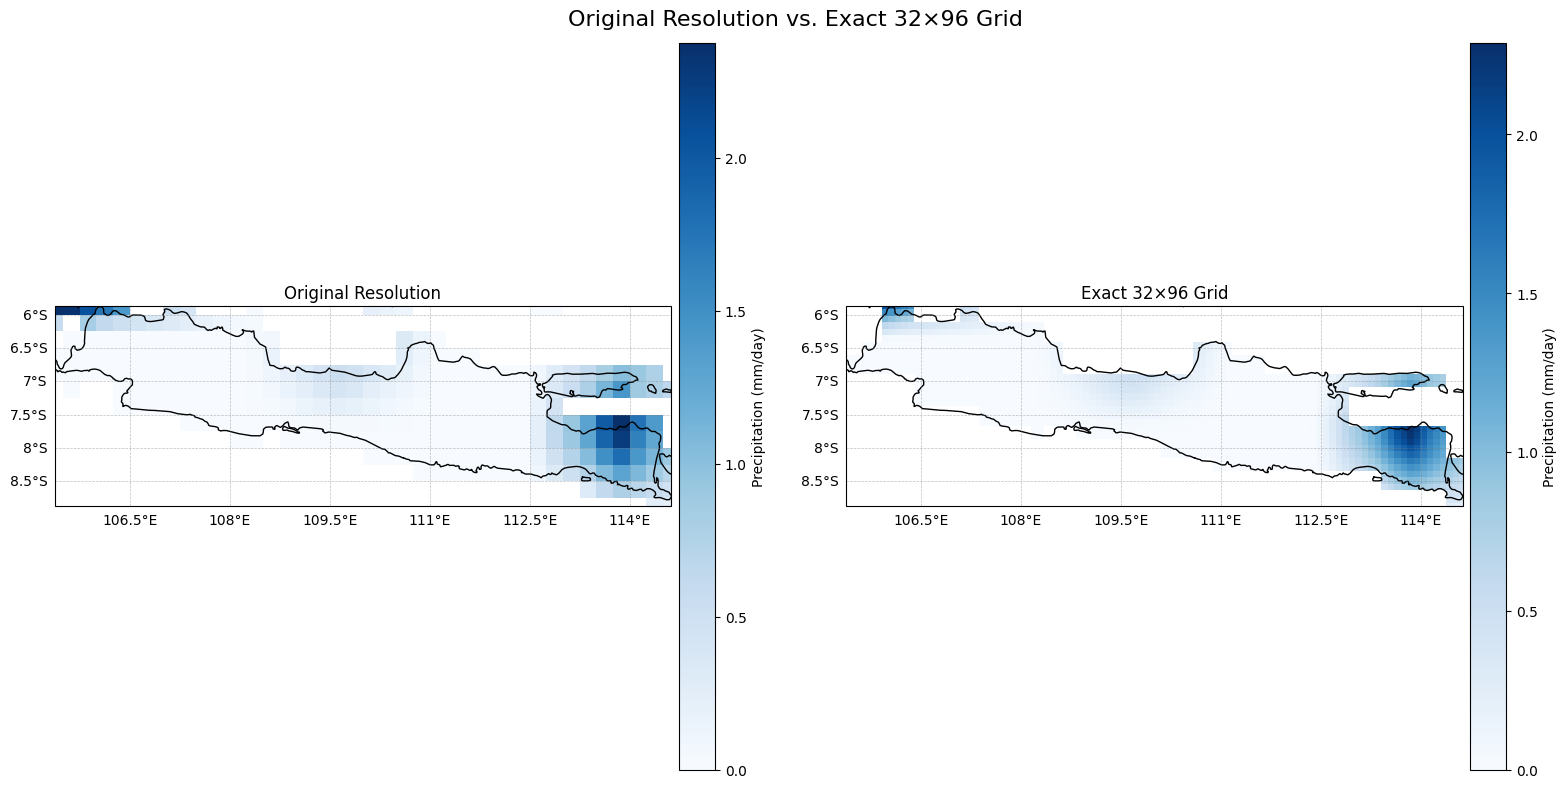

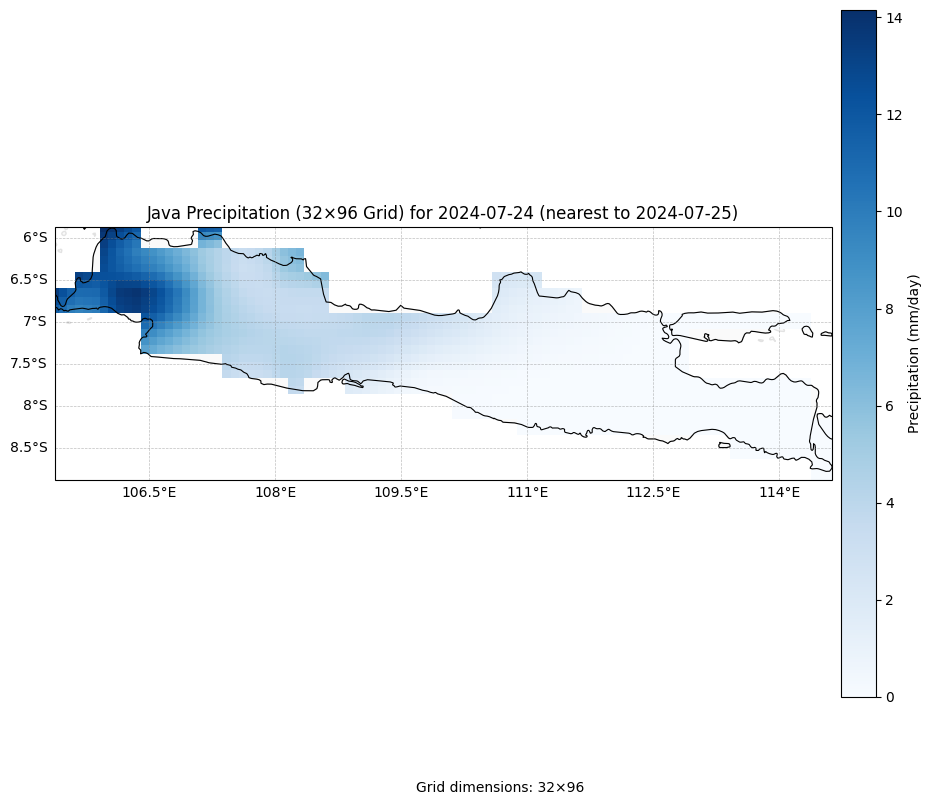

Data array shape: (32, 96)


In [13]:
# Define exact number of points needed
lat_points = 32
lon_points = 96

# Calculate exact lat/lon arrays to get the precise dimensions
lat_min, lat_max = ds_java_2024_mm.lat.min().values, ds_java_2024_mm.lat.max().values
lon_min, lon_max = ds_java_2024_mm.lon.min().values, ds_java_2024_mm.lon.max().values

# Create evenly spaced arrays with exactly the right number of points
# For latitude, need to handle ascending vs descending order
if ds_java_2024_mm.lat[0] > ds_java_2024_mm.lat[-1]:  # Descending
    new_lat = np.linspace(lat_max, lat_min, lat_points)  # Descending order
else:  # Ascending
    new_lat = np.linspace(lat_min, lat_max, lat_points)  # Ascending order
    
new_lon = np.linspace(lon_min, lon_max, lon_points)

print(f"Creating exact grid with dimensions: {len(new_lat)} × {len(new_lon)}")

# Perform interpolation to exact grid
ds_java_exact_mm = ds_java_2024_mm.interp(lat=new_lat, lon=new_lon, method="linear")

# Verify dimensions
print(f"Original dimensions: {ds_java_2024_mm.dims}")
print(f"New exact dimensions: {ds_java_exact_mm.dims}")

# Confirm we have exactly 32×96
if len(ds_java_exact_mm.lat) == 32 and len(ds_java_exact_mm.lon) == 96:
    print("SUCCESS: Dimensions match exactly 32×96!")
else:
    print(f"ERROR: Dimensions still don't match. Got {len(ds_java_exact_mm.lat)}×{len(ds_java_exact_mm.lon)}")

# Visualize the result
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Plot the first timestep for comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Original resolution
im1 = ds_java_2024_mm[pr_var].isel(time=0).plot(
    ax=axes[0], transform=ccrs.PlateCarree(), cmap='Blues',
    add_colorbar=False
)
plt.colorbar(im1, ax=axes[0], orientation='vertical', pad=0.01, label='Precipitation (mm/day)')
axes[0].set_title(f'Original Resolution')
axes[0].coastlines(resolution='10m')
axes[0].add_feature(cfeature.BORDERS, linestyle=':')

# Exact 32×96 resolution
im2 = ds_java_exact_mm[pr_var].isel(time=0).plot(
    ax=axes[1], transform=ccrs.PlateCarree(), cmap='Blues',
    add_colorbar=False
)
plt.colorbar(im2, ax=axes[1], orientation='vertical', pad=0.01, label='Precipitation (mm/day)')
axes[1].set_title('Exact 32×96 Grid')
axes[1].coastlines(resolution='10m')
axes[1].add_feature(cfeature.BORDERS, linestyle=':')

# Set the same extent for both plots
for ax in axes:
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

plt.suptitle('Original Resolution vs. Exact 32×96 Grid', fontsize=16)
plt.tight_layout()
plt.savefig('java_exact_32x96_grid.png', dpi=300, bbox_inches='tight')
plt.show()

# Now we have a dataset that exactly matches the GAN input dimensions
# Let's create a function to visualize a sample from this exact grid
def plot_exact_java_grid(date_str, pr_var='pr', cmap='Blues', 
                        figsize=(10, 8), vmin=None, vmax=None):
    """
    Plot precipitation data for the exact 32×96 Java grid for a specific date.
    """
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import numpy as np
    import pandas as pd
    
    # Convert date string to pandas datetime
    date = pd.to_datetime(date_str)
    
    # Find the nearest time in the dataset
    time_index = np.abs(ds_java_exact_mm.time.values - np.datetime64(date)).argmin()
    actual_date = pd.to_datetime(ds_java_exact_mm.time.values[time_index])
    
    # Get data for this date
    data = ds_java_exact_mm[pr_var].isel(time=time_index)
    
    # Check units for title
    units = data.attrs.get('units', 'mm/day')
    
    # Set up the figure with cartopy projection
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Plot the data
    im = data.plot(ax=ax, cmap=cmap, transform=ccrs.PlateCarree(),
                  add_colorbar=False, vmin=vmin, vmax=vmax)
    
    # Add a colorbar - vertical on the right
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.01, 
                       label=f'Precipitation ({units})')
    
    # Add coastlines and features
    ax.coastlines(resolution='10m', linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.1)
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Set extent to Java Island
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    
    # Set title
    if date != actual_date:
        title = f"Java Precipitation (32×96 Grid) for {actual_date.strftime('%Y-%m-%d')} (nearest to {date.strftime('%Y-%m-%d')})"
    else:
        title = f"Java Precipitation (32×96 Grid) for {date.strftime('%Y-%m-%d')}"
    
    ax.set_title(title)
    
    # Add grid dimensions for reference
    plt.annotate(f"Grid dimensions: {len(ds_java_exact_mm.lat)}×{len(ds_java_exact_mm.lon)}", 
                xy=(0.5, 0.01), xycoords='figure fraction', 
                ha='center', fontsize=10)
    
    plt.tight_layout()
    
    return fig, ax, data.values

# Example usage:
fig, ax, data_array = plot_exact_java_grid('2024-07-25')
plt.savefig('java_exact_32x96_sample.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Data array shape: {data_array.shape}")